<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Осень 2020</b></h3>


В этой домашке вы напишите свой класс логистической регрессии для многоклассовой классификации, а также логистическую регрессию с регуляризацией.

In [1]:
import numpy as np
import pandas as pd
import scipy.linalg as sla
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [2]:
np.random.seed(42)

### 1. Градиентный спуск: повторение

Рассмотрим функцию от двух переменных:

In [3]:
def f(x):
  """
  :param x: np.array(np.float) размерности 2
  :return: np.float
  """
  return np.sum(np.sin(x)**2, axis=0)

Обратите внимание, что $x$ - numpy-array размерности 2.

***Reminder:***  
Что мы хотим? Мы хотим найти минимум этой функции (в машинному обучении мы обычно хотим найти минимум **функции потерь**, например, MSE), а точнее найти $x_1$ и $x_2$ такие, что при них значение $f(x_1,x_2)$ минимально, то есть *точку экстремума*.  
  
Как мы будем искать эту точку? Используем методы оптимизации (в нашем случае - *минимизации*). Одним из таких методов и является **градиентный спуск**. 

Реализуем функцию, которая будет осуществлять градиентный спуск для функции $f$:

*Примечание:* Вам нужно посчитать частные производные именно **аналитически** и **переписать их в код**, а не считать производные численно (через отношение приращения функции к приращению аргумента) -- в этих двух случаях могут различаться ответы, поэтому будьте внимательны.

In [4]:
def grad_f(x): 
  """
  Градиент функциии f, определенной выше.
  :param x: np.array(np.float) размерности 2
  :return: np.array(np.float) размерности 2
  """
  return np.array([np.sum(np.sin(2 * x[0])), np.sum(np.sin(2 * x[1]))])

In [5]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    функция, которая реализует градиентный спуск в минимум для функции f от двух переменных. 
        :param f: скалярная функция двух переменных
        :param grad_f: градиент функции f (вектор размерности 2)
        :param lr: learning rate алгоритма
        :param num_iter: количество итераций градиентного спуска
        :return: np.array пар вида (x, f(x))
    """
    if x0 is None:
        x0 = np.random.random(2)
    
    # будем сохранять значения аргументов и значений функции 
    # в процессе град. спуска в переменную history
    history = []
    
    # итерация цикла -- шаг градиентнго спуска
    curr_x = x0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_x, f(curr_x)))
        history.append(entry)
        # обновите curr_x
        curr_x -= lr * grad_f(curr_x)

    return np.vstack(history)

In [6]:
x6 = [0.5456, 0.1241]
print(f(x6))

0.2846113695984936


In [7]:
steps = grad_descent_2d(f, grad_f, lr=0.2, num_iter=20)

Визуализируем точки градиентного спуска на 3D-графике нашей функции. Звездочками будут обозначены точки (тройки $x_1, x_2, f(x_1, x_2)$), по которым Ваш алгоритм градиентного спуска двигался к минимуму.

(Для того, чтобы написовать этот график, мы и сохраняли значения $cur\_x_1, cur\_x_2, f(cur\_x_1, cur\_x_2)$ в `steps` в процессе спуска)

Если у Вас правильно написана функция `grad_descent_2d`, то звездочки на картинке должны сходиться к одной из точку минимума функции. Вы можете менять начальные приближения алгоритма, значения `lr` и `num_iter` и получать разные результаты.

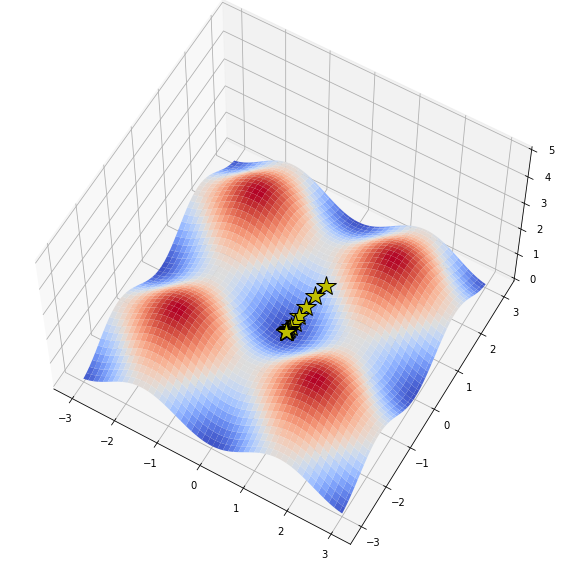

In [8]:
# %matplotlib osx

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

path = []

X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

fig = plt.figure(figsize=(16, 10))
ax = fig.gca(projection='3d')

ax.plot_surface(X, Y, f([X, Y]), cmap=cm.coolwarm, zorder=2)

ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
        marker='*', markersize=20, zorder=3, 
        markerfacecolor='y', lw=3, c='black')

ax.set_zlim(0, 5)
ax.view_init(elev=60)
plt.show()

Посмотрим на график значений функции от шага

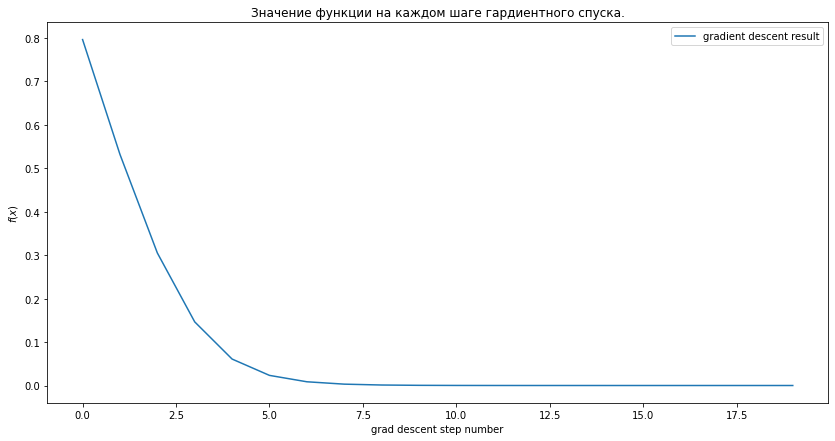

In [9]:
plt.figure(figsize=(14,7))
plt.xlabel('grad descent step number')
plt.ylabel('$f(x)$')
plt.title('Значение функции на каждом шаге гардиентного спуска.')

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label='gradient descent result')
plt.legend()

Когда вы используете градиентный спуск всегда нужно проверять, сошелся ли он. К сожалению для большинства моделей не получится построить 3D график, поэтому обязательно нужно смотреть на то, как менялся лосс на каждом шаге градиентного спуска.

# 2. Генератор батчей

Обычно генерация батчей отличается от той, которую мы использовали в семинаре. Мы выбирали *batch_size* случайных строчек на каждом шаге, но у такого подхода есть минусы. Основной заключается в том, что некоторые строчки из обучающего датасета могут попадаться значительно реже, чем другие. 

Чтобы это исправить обучение делят на эпохи. Мы хотим, чтобы в течение одной эпохи модель обучилась на каждом примере один раз. Для этого нужно перемешать строчки в датасете и каждый раз брать очередные *batch_size* строчек. 

Может так получится, что размер датасета не делится на *batch_size*, тогда последний батч будет состоять из нескольких последних строк и его размер будет меньше, чем *batch_size*. Такой батч иногда выкидывают и просто не используют. Именно так вам нужно поступить в этом задании.

Напишите генератор батчей, который будет принимать на вход признаки, ответы и размер батча. Генератор должен возвращать tuple из ($X_{batch}$, $y_{batch}$). Если размер датасета не делится на batch_size, то последний маленький батч возвращать не нужно. 

Подробнее про Python генераторы можно прочитать здесь:

[Документация](https://wiki.python.org/moin/Generators)

[Описание на русском](https://pythoner.name/list-generator)

Чтобы не перемешивать сам датасет воспользуйтесь np.random.permutation(len(X))


In [10]:
def generate_batches(X, y, batch_size):
    assert len(X) == len(y)
    np.random.seed(42)
    X = np.array(X)
    y = np.array(y)
    perm = np.random.permutation(len(X))
    # YOUR CODE with yield
    num_batches = len(X) // batch_size
    for i in np.arange(num_batches):
        ind = perm[i * batch_size : (i + 1) * batch_size] 
        yield (X[ind], y[ind])


Проверим, что наш генератор батчей премешивает датасет и каждый эелмент встречается один раз:

In [11]:
X_fake = np.arange(100)[:, np.newaxis]
y_fake = np.arange(100) + 1000

X_reconstructed, y_reconstructed = [], []
for X_batch, y_batch in generate_batches(X_fake, y_fake, 10):
    X_reconstructed.append(X_batch)
    y_reconstructed.append(y_batch)

X_reconstructed = np.concatenate(X_reconstructed)
y_reconstructed = np.concatenate(y_reconstructed)

assert (X_fake != X_reconstructed).all()
assert (y_fake != y_reconstructed).all()

assert (np.sort(X_reconstructed, axis=0) == X_fake).all

Попробуем теперь *batch_size* не делящий размер датасета.

In [12]:
X_fake = np.arange(100)[:, np.newaxis]
y_fake = np.arange(100) + 1000

num_batches = 0
for X_batch, y_batch in generate_batches(X_fake, y_fake, 7):
    num_batches += 1

assert num_batches == len(X_fake) // 7

# 3. Логистическая регрессия с $l_1$ и $l_2$ регуляризацией. (elastic net)

Ваша задача -- написать класс логистической регрессии с обеими ругеляризациями и потимизацией с помощью SGD, используя генератор батчей, который вы написали выше.


In [32]:
def logit(x, w):
    return np.dot(x, w)

def sigmoid(h):
    return 1. / (1 + np.exp(-h))

class MyElasticLogisticRegression(object):
    def __init__(self, l1_coef, l2_coef):
        self.l1_coef = l1_coef
        self.l2_coef = l2_coef
        self.w = None
    
    def fit(self, X, y, epochs=10, lr=0.1, batch_size=100):
        n, k = X.shape        
        if self.w is None:
            np.random.seed(42)
            self.w = np.random.randn(k + 1)

        X_train = np.concatenate((np.ones((n, 1)), X), axis=1)
        
        # Положите в лист losses лосс на каждом батче. Не нужно усреднять лосс по эпохе.
        losses = []
        #### YOUR CODE (train loop here, use self.get_grad)####
        for i in range(epochs):
            for X_, y_ in generate_batches(X_train, y, batch_size):
                z = sigmoid(logit(X_, self.w))
                self.w -= self.get_grad(X_, y_, z) * lr
                losses.append(self.__loss(y_, z))
        return losses
    
    def get_grad(self, X_batch, y_batch, predictions):
        """
        Принимает на вход X_batch с уже добавленной колонкой единиц. 
        НЕ НУЖНО РЕГУЛЯРИЗИРОВАТЬ BIAS.
        """
        wc = np.copy(self.w)
        wc[0] = 0
        grad = np.dot(X_batch.T, (predictions - y_batch)) / len(y)
        grad += 2 * self.l2_coef * wc
        grad += self.l1_coef * np.sign(wc)
        
        return grad
        
    def predict_proba(self, X):
        n, k = X.shape
        X_ = np.concatenate((np.ones((n, 1)), X), axis=1)
        return sigmoid(logit(X_, self.w))

    def predict(self, X, threshold=0.5):
        return self.predict_proba(X) >= threshold
    
    def get_weights(self):
        return self.w
      
    def __loss(self, y, p):  
        p = np.clip(p, 1e-10, 1 - 1e-10)
        return -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

Протестируем на искусственных данных:


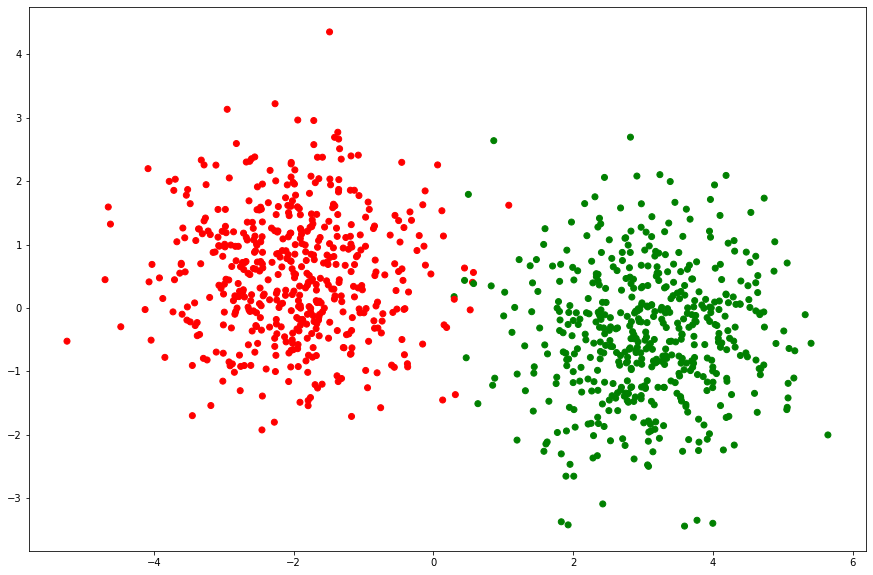

In [33]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=[[-2,0.5],[3,-0.5]], cluster_std=1, random_state=42)

colors = ("red", "green")
colored_y = np.zeros(y.size, dtype=str)

for i, cl in enumerate([0,1]):
    colored_y[y == cl] = str(colors[i])
    
plt.figure(figsize=(15,10))
plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.show()

In [34]:
clf = MyElasticLogisticRegression(0.1, 0.1)
clf.fit(X, y, epochs=1000)
w = clf.get_weights()

<ipython-input-35-605a99e9b6c0>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


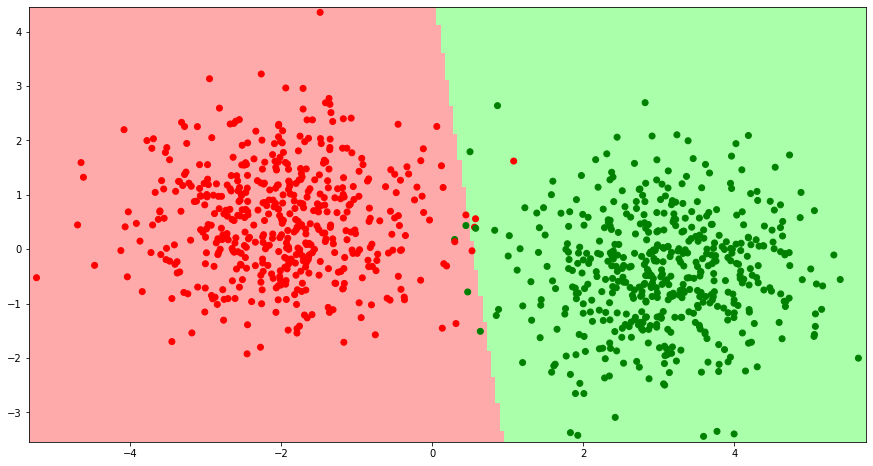

In [35]:
from matplotlib.colors import ListedColormap

plt.figure(figsize=(15,8))

eps = 0.1
xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]) - eps, np.max(X[:,0]) + eps, 200),
                     np.linspace(np.min(X[:,1]) - eps, np.max(X[:,1]) + eps, 200))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

plt.scatter(X[:, 0], X[:, 1], c=colored_y)

Теперь протестируем на датасете MNIST. Это очень простой класический датасет, на котором часто тестируются модели. С помощью нейронных сетей люди научились получать на нем качество 99.84%. 

Датасет состоит из черно-белых картинок с цифрами. ![mnist-3.0.1.png](https://www.researchgate.net/profile/Steven_Young11/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Так как мы сделали классификатор для двух классов, то мы выберем из всех картинок только картинки 0 и 1, првратим их из двумерной матрицы в вектор и обучим нашу модель.

In [ ]:
data = pd.read_csv('./train.csv')
data.head()

Данные выглядят как таблица, первая колонка которой это лейбел -- цифра, которая изображена на картинке, а следующие 784 колонки это значения от 0 до 255, описывающие все пиксели картинки 28х28. То есть нам не придется делать reshape и превращать матрицу в вектор, так как это уже сделано.

In [ ]:
X = data.iloc[:, 1:]
y = data.iloc[:, 1]

# Выберем только картинки, где изображен 0 и 1
X = X[(y == 0) | (y == 1)]
y = y[(y == 0) | (y == 1)]

Для оценки модели мы используем кросс валидацию.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# YOUR CODE
# Сделайте sklearn pipeline с StandarScaler и MyElasticLogisticRegression и проверьте точность с помощью cross_val_score.
# в качестве scorer используйте 'accuracy'. Эта часть не проверяется в степике.


print(f"Mean accuracy of Logistic Regression for two classes is {mean_accuracy}")